In [1]:
import xt_fns as xf
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import batman
from astropy.io import ascii
from astropy.table import Table
import astropy
from contextlib import closing
from astropy.time import Time
from scipy.stats import linregress
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter

In [2]:
#Stellar parameters
Rs = 0.780 #radius (Rsun)
Ms = 0.823 #mass (Msun)
T = 0.34 #kT of corona in keV

#get emission scale height in stellar radii
He = xf.HfromT(T, Rs, Ms)
#get emission scale height in batman coordinates
he = xf.hfromH(He)


#set up x array for 10001 steps from x=0 to x=1
x = np.linspace(0, 1, 10001)
#number of emission scale heights to calculate corona out to
Nscale = 6
#photosphere edge in batman coords
Rx = xf.calcRx(he, Nscale)
#integral values
intVals = xf.get_intVals(he, Nscale)

In [3]:
#planetary parameters
RpRs = 0.15641 #Rp/Rs
aRs = 8.863 #a/Rs
inc = 85.710 #inclination
t0 = 1 #phase of transit centre

#set up the object to store the transit parameters
params = batman.TransitParams()
params.t0 = t0               #time of inferior conjunction
params.per = 1               #orbital period - set to 1 to keep within phase definitions
params.rp = RpRs * Rx        #planet radius (in units of stellar radii)
params.a = aRs * Rx          #semi-major axis (in units of stellar radii)
params.inc = inc             #orbital inclination (in degrees)
params.ecc = 0.              #eccentricity
params.w = 90.               #longitude of periastron (in degrees)
params.limb_dark = "custom"  #limb darkening model
params.u = [0]*6             #limb darkening coefficients
params.u[0] = intVals


#initialise a batman model at the calcuation phase times
#Setting up times for model
phaSt, phaFi = 0.9, 1.1 #phases to model
numBins = 500 #number of bins to calculate the light curve at
binPhases = np.linspace(phaSt, phaFi, numBins) #bin centres

#set up batman model
mod = batman.TransitModel(params, binPhases)


In [4]:
#Change the coronal temperature
T2 = 0.05
T3 = 1.00
T4 = 1.75

#get emission scale height in stellar radii
He2 = xf.HfromT(T2, Rs, Ms)
#get emission scale height in batman coordinates
he2 = xf.hfromH(He2)
#get emission scale height in stellar radii
He3 = xf.HfromT(T3, Rs, Ms)
#get emission scale height in batman coordinates
he3 = xf.hfromH(He3)
#get emission scale height in stellar radii
He4 = xf.HfromT(T4, Rs, Ms)
#get emission scale height in batman coordinates
he4 = xf.hfromH(He4)

#photosphere edge in batman coords
Rx2 = xf.calcRx(he2, Nscale)
#integral values
intVals2 = xf.get_intVals(he2, Nscale)
#photosphere edge in batman coords
Rx3 = xf.calcRx(he3, Nscale)
#integral values
intVals3 = xf.get_intVals(he3, Nscale)
#photosphere edge in batman coords
Rx4 = xf.calcRx(he4, Nscale)
#integral values
intVals4 = xf.get_intVals(he4, Nscale)

#choose radii to try (factor of optical radii)
radii = np.arange(1.0,3.01,0.1)

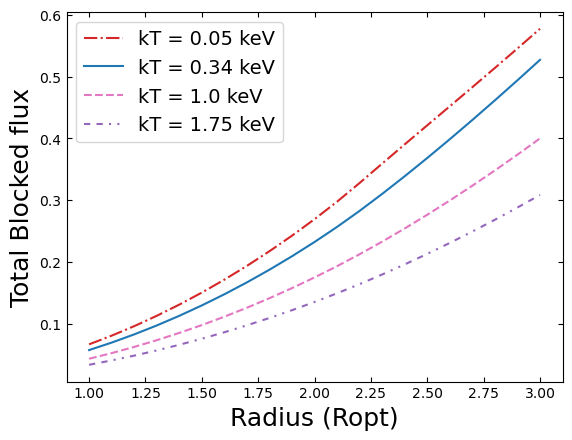

In [5]:
def change_h_rad_b(model, newVals, newRad, newb, param, newRx, ars):
    newInc = np.rad2deg(np.arccos(newb/ars))
    param.inc = newInc
    param.u[0] = newVals
    param.rp = newRad * RpRs * newRx
    params.a = ars * newRx
    flux = model.light_curve(param)
    return flux
    

#set up arrays
fluxes1 = np.zeros(shape=(len(radii),numBins))
fluxes2 = np.zeros(shape=(len(radii),numBins))
fluxes3 = np.zeros(shape=(len(radii),numBins))
fluxes4 = np.zeros(shape=(len(radii),numBins))

#loop over radii
for i,rad in enumerate(radii):
    fluxes1[i] = change_h_rad_b(mod, intVals, rad, 0.66, params, Rx, aRs)
    fluxes2[i] = change_h_rad_b(mod, intVals2, rad, 0.66, params, Rx2, aRs)
    fluxes3[i] = change_h_rad_b(mod, intVals3, rad, 0.66, params, Rx3, aRs)
    fluxes4[i] = change_h_rad_b(mod, intVals4, rad, 0.66, params, Rx4, aRs)

    
#find total light missing per point
miss1 = np.trapz((1-fluxes1), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2 = np.trapz((1-fluxes2), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss3 = np.trapz((1-fluxes3), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss4 = np.trapz((1-fluxes4), axis=1, dx=np.mean(np.diff(binPhases))) * 100

#plot
plt.plot(radii,miss2, label='kT = %s keV' % T2, color='C3', ls='-.')
plt.plot(radii,miss1, label='kT = %s keV' % T, color='C0')
plt.plot(radii,miss3, label='kT = %s keV' % T3, color='C6', ls='--')
plt.plot(radii,miss4, label='kT = %s keV' % T4, color='C4', ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)))


plt.xlabel('Radius (Ropt)',fontsize=18)
plt.ylabel('Total Blocked flux',fontsize=18)
plt.legend(fontsize=14)

plt.savefig('varyR_detectability_lin.pdf', dpi=300)

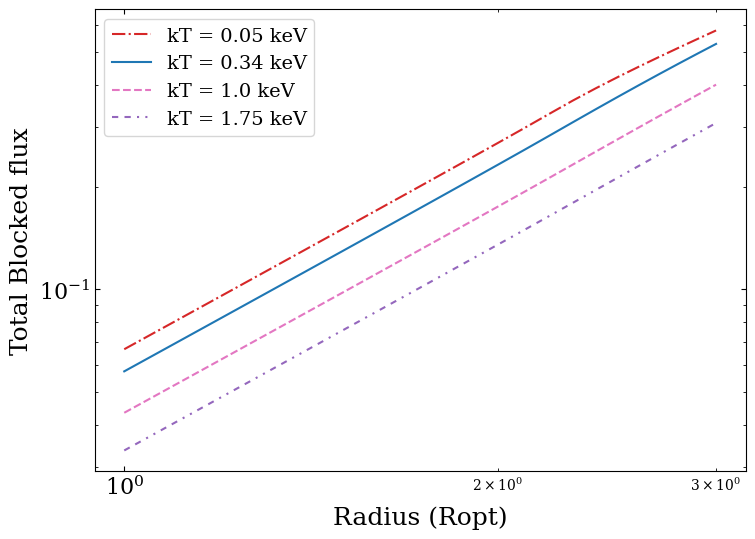

In [6]:
plt.rc('font', family='serif')

plt.figure(figsize=(8.4,6.0))

plt.plot(radii,miss2, label='kT = %s keV' % T2, color='C3', ls='-.')
plt.plot(radii,miss1, label='kT = %s keV' % T, color='C0')
plt.plot(radii,miss3, label='kT = %s keV' % T3, color='C6', ls='--')
plt.plot(radii,miss4, label='kT = %s keV' % T4, color='C4', ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)))


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (Ropt)',fontsize=18)
plt.ylabel('Total Blocked flux',fontsize=18)
plt.tick_params(labelsize=16)

plt.legend(fontsize=14)

plt.savefig('varyR_detectability_log.pdf', dpi=300)

In [7]:
#log the radii and blocked fluxes
logR = np.log10(radii)
log1 = np.log10(miss1)
log2 = np.log10(miss2)
log3 = np.log10(miss3)
log4 = np.log10(miss4)

#linear regression
lr1 = linregress(logR,log1)
lr2 = linregress(logR,log2)
lr3 = linregress(logR,log3)
lr4 = linregress(logR,log4)

print(lr2)
print(lr1)
print(lr3)
print(lr4)

LinregressResult(slope=1.9882938402407753, intercept=-1.1721789408618486, rvalue=0.9997955937580321, pvalue=1.1640979991036624e-33, stderr=0.009224278964740765, intercept_stderr=0.0028863318487030954)
LinregressResult(slope=2.0285780741039705, intercept=-1.243287829173584, rvalue=0.9999870298083103, pvalue=4.893341637408032e-45, stderr=0.002370321994956893, intercept_stderr=0.0007416878752124566)
LinregressResult(slope=2.026258945270317, intercept=-1.3654205985172334, rvalue=0.9999916802552906, pvalue=7.205556975009706e-47, stderr=0.001896229298374959, intercept_stderr=0.0005933414456852763)
LinregressResult(slope=2.020571476962542, intercept=-1.4758036376100048, rvalue=0.9999944285504858, pvalue=1.5970739995765303e-48, stderr=0.0015473848122891892, intercept_stderr=0.00048418592748352183)


## b=0

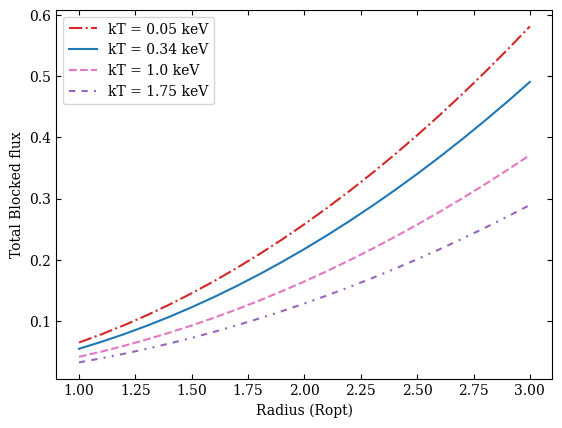

In [8]:
#set up arrays
fluxes1b0 = np.zeros(shape=(len(radii),numBins))
fluxes2b0 = np.zeros(shape=(len(radii),numBins))
fluxes3b0 = np.zeros(shape=(len(radii),numBins))
fluxes4b0 = np.zeros(shape=(len(radii),numBins))

#loop over radii
for i,rad in enumerate(radii):
    fluxes1b0[i] = change_h_rad_b(mod, intVals, rad, 0, params, Rx, aRs)
    fluxes2b0[i] = change_h_rad_b(mod, intVals2, rad, 0, params, Rx2, aRs)
    fluxes3b0[i] = change_h_rad_b(mod, intVals3, rad, 0, params, Rx3, aRs)
    fluxes4b0[i] = change_h_rad_b(mod, intVals4, rad, 0, params, Rx4, aRs)
    
    
#find total light missing per point
miss1b0 = np.trapz((1-fluxes1b0), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2b0 = np.trapz((1-fluxes2b0), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss3b0 = np.trapz((1-fluxes3b0), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss4b0 = np.trapz((1-fluxes4b0), axis=1, dx=np.mean(np.diff(binPhases))) * 100

    
#plot
plt.plot(radii,miss2b0, label='kT = %s keV' % T2, color='C3', ls='-.')
plt.plot(radii,miss1b0, label='kT = %s keV' % T, color='C0')
plt.plot(radii,miss3b0, label='kT = %s keV' % T3, color='C6', ls='--')
plt.plot(radii,miss4b0, label='kT = %s keV' % T4, color='C4', ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)))

plt.xlabel('Radius (Ropt)')
plt.ylabel('Total Blocked flux')
plt.legend()

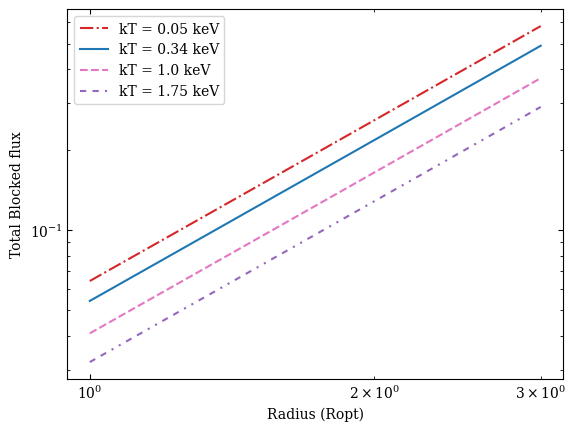

In [9]:
plt.plot(radii,miss2b0, label='kT = %s keV' % T2, color='C3', ls='-.')
plt.plot(radii,miss1b0, label='kT = %s keV' % T, color='C0')
plt.plot(radii,miss3b0, label='kT = %s keV' % T3, color='C6', ls='--')
plt.plot(radii,miss4b0, label='kT = %s keV' % T4, color='C4', ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (Ropt)')
plt.ylabel('Total Blocked flux')
plt.legend()

In [10]:
#log the radii and blocked fluxes
logR = np.log10(radii)
log1b0 = np.log10(miss1b0)
log2b0 = np.log10(miss2b0)
log3b0 = np.log10(miss3b0)
log4b0 = np.log10(miss4b0)

#linear regression
lr1 = linregress(logR,log1b0)
lr2 = linregress(logR,log2b0)
lr3 = linregress(logR,log3b0)
lr4 = linregress(logR,log4b0)

print(lr2)
print(lr1)
print(lr3)
print(lr4)

LinregressResult(slope=2.002375847109325, intercept=-1.1909353734055714, rvalue=0.999999918971853, pvalue=5.606314164269828e-66, stderr=0.0001849276179105107, intercept_stderr=5.78649534906932e-05)
LinregressResult(slope=2.004274827959416, intercept=-1.2657609232456828, rvalue=0.9999997868481184, pvalue=5.485083131868089e-62, stderr=0.00030022034817272044, intercept_stderr=9.394073573359323e-05)
LinregressResult(slope=2.0044587741640045, intercept=-1.3871997552415165, rvalue=0.9999997754992714, pvalue=8.978519772379312e-62, stderr=0.00030813730251560333, intercept_stderr=9.641799791873936e-05)
LinregressResult(slope=2.0039424778615715, intercept=-1.4948249570524403, rvalue=0.9999998332557711, pvalue=5.322539341618615e-63, stderr=0.00026549045309490606, intercept_stderr=8.307354463406324e-05)


## Try b=1

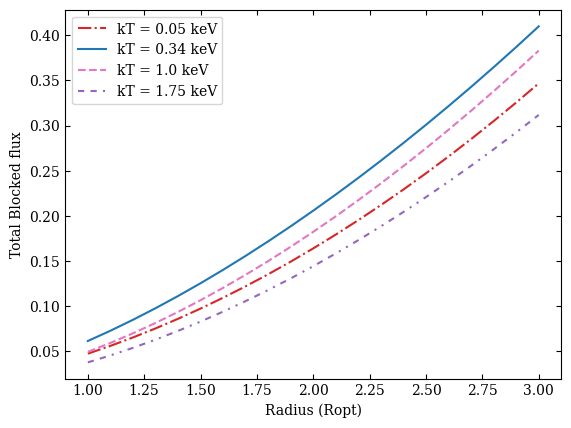

In [11]:
#set up arrays
fluxes1b1 = np.zeros(shape=(len(radii),numBins))
fluxes2b1 = np.zeros(shape=(len(radii),numBins))
fluxes3b1 = np.zeros(shape=(len(radii),numBins))
fluxes4b1 = np.zeros(shape=(len(radii),numBins))

#loop over radii
for i,rad in enumerate(radii):
    fluxes1b1[i] = change_h_rad_b(mod, intVals, rad, 1, params, Rx, aRs)
    fluxes2b1[i] = change_h_rad_b(mod, intVals2, rad, 1, params, Rx2, aRs)
    fluxes3b1[i] = change_h_rad_b(mod, intVals3, rad, 1, params, Rx3, aRs)
    fluxes4b1[i] = change_h_rad_b(mod, intVals4, rad, 1, params, Rx4, aRs)
    
    
#find total light missing per point
miss1b1 = np.trapz((1-fluxes1b1), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2b1 = np.trapz((1-fluxes2b1), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss3b1 = np.trapz((1-fluxes3b1), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss4b1 = np.trapz((1-fluxes4b1), axis=1, dx=np.mean(np.diff(binPhases))) * 100

    
#plot
plt.plot(radii,miss2b1, label='kT = %s keV' % T2, color='C3', ls='-.')
plt.plot(radii,miss1b1, label='kT = %s keV' % T, color='C0')
plt.plot(radii,miss3b1, label='kT = %s keV' % T3, color='C6', ls='--')
plt.plot(radii,miss4b1, label='kT = %s keV' % T4, color='C4', ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)))

plt.xlabel('Radius (Ropt)')
plt.ylabel('Total Blocked flux')
plt.legend()

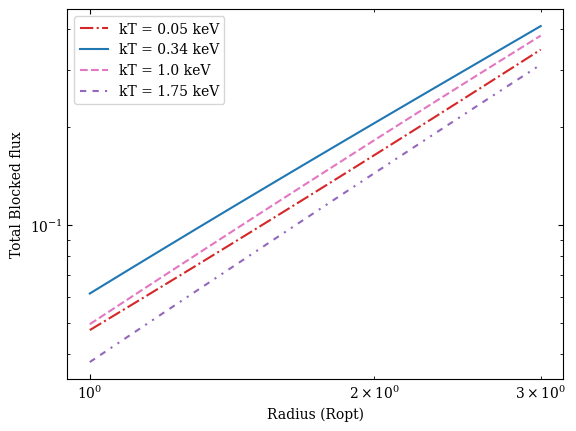

In [12]:
plt.plot(radii,miss2b1, label='kT = %s keV' % T2, color='C3', ls='-.')
plt.plot(radii,miss1b1, label='kT = %s keV' % T, color='C0')
plt.plot(radii,miss3b1, label='kT = %s keV' % T3, color='C6', ls='--')
plt.plot(radii,miss4b1, label='kT = %s keV' % T4, color='C4', ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (Ropt)')
plt.ylabel('Total Blocked flux')
plt.legend()

In [13]:
#log the radii and blocked fluxes
logR = np.log10(radii)
log1b1 = np.log10(miss1b1)
log2b1 = np.log10(miss2b1)
log3b1 = np.log10(miss3b1)
log4b1 = np.log10(miss4b1)

#linear regression
lr1 = linregress(logR,log1b1)
lr2 = linregress(logR,log2b1)
lr3 = linregress(logR,log3b1)
lr4 = linregress(logR,log4b1)

print(lr2)
print(lr1)
print(lr3)
print(lr4)

LinregressResult(slope=1.8146213940419813, intercept=-1.329345196700232, rvalue=0.999963983762319, pvalue=8.004064266421595e-41, stderr=0.003533337539259718, intercept_stderr=0.0011056023685717055)
LinregressResult(slope=1.7223357189570339, intercept=-1.206778037028272, rvalue=0.9999714704783745, pvalue=8.747550449085909e-42, stderr=0.0029847814938453246, intercept_stderr=0.0009339559135229901)
LinregressResult(slope=1.8614431030701732, intercept=-1.3015769002564883, rvalue=0.9999703646500369, pvalue=1.2554011716561245e-41, stderr=0.0032877792225145873, intercept_stderr=0.0010287657081623014)
LinregressResult(slope=1.9197846076459093, intercept=-1.420039106137474, rvalue=0.9999894329397734, pvalue=6.985275461930473e-46, stderr=0.0020247491994007465, intercept_stderr=0.0006335560884709984)


## Plot all three together

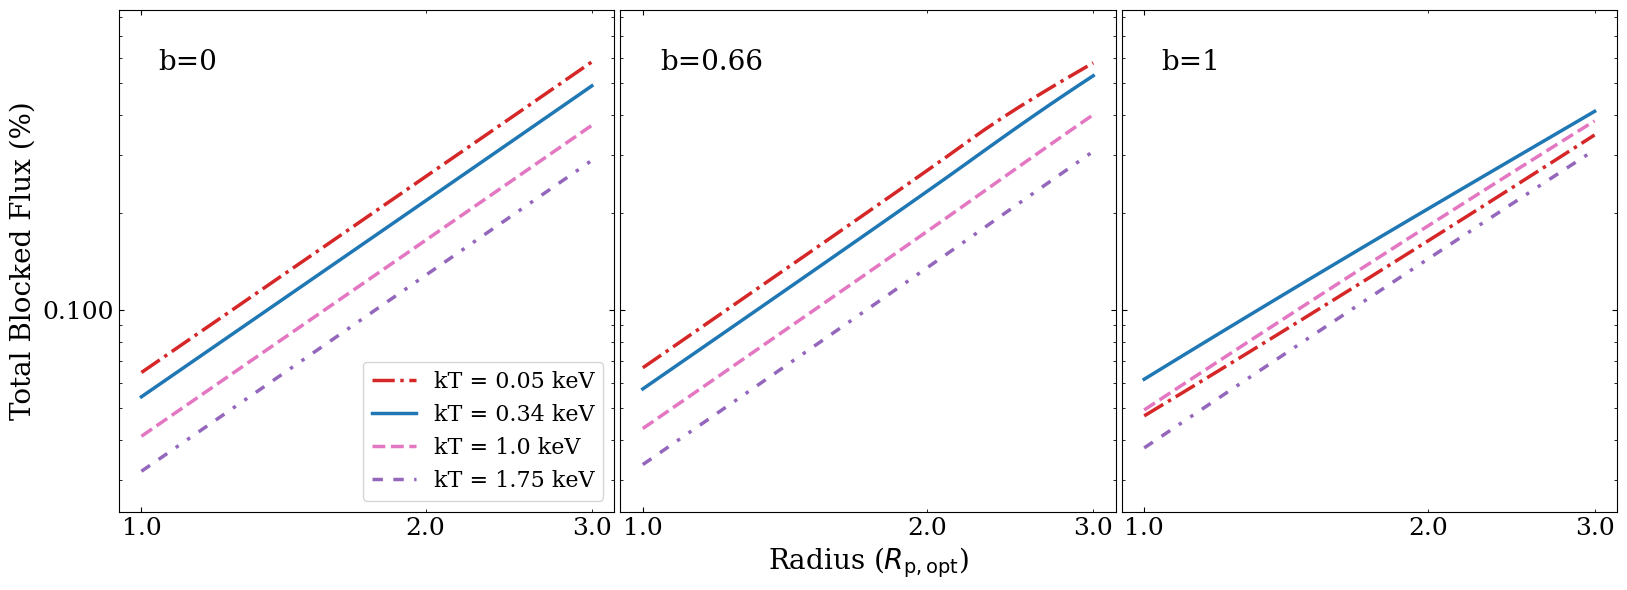

In [14]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(16.4,6.0))

ax1 = fig.add_subplot(131)

ax1.plot(radii,miss2b0, label='kT = %s keV' % T2, color='C3', ls='-.', lw=2.5)
ax1.plot(radii,miss1b0, label='kT = %s keV' % T, color='C0', lw=2.5)
ax1.plot(radii,miss3b0, label='kT = %s keV' % T3, color='C6', ls='--', lw=2.5)
ax1.plot(radii,miss4b0, label='kT = %s keV' % T4, color='C4', ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), lw=2.5)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Total Blocked Flux (%)',fontsize=20)
ax1.legend(fontsize=16, loc='lower right')
ax1.tick_params(labelsize=18)
ax1.tick_params(axis='x', which='minor', labelsize=18)
ax1.set_ylim(0.024,0.84)
ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.xaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.annotate('b=0', xy=(0.08, 0.88), xycoords='axes fraction', fontsize=20)


ax2 = fig.add_subplot(132)

ax2.plot(radii,miss2, label='kT = %s keV' % T2, color='C3', ls='-.', lw=2.5)
ax2.plot(radii,miss1, label='kT = %s keV' % T, color='C0', lw=2.5)
ax2.plot(radii,miss3, label='kT = %s keV' % T3, color='C6', ls='--', lw=2.5)
ax2.plot(radii,miss4, label='kT = %s keV' % T4, color='C4', ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), lw=2.5)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Radius ($R_{\rm p,opt}$)',fontsize=20)
ax2.tick_params(labelsize=18)
ax2.tick_params(axis='x', which='minor', labelsize=18)
ax2.set_yticklabels([])
ax2.set_ylim(0.024,0.84)
ax2.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax2.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.xaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
ax2.annotate('b=0.66', xy=(0.08, 0.88), xycoords='axes fraction', fontsize=20)


ax3 = fig.add_subplot(133)

ax3.plot(radii,miss2b1, label='kT = %s keV' % T2, color='C3', ls='-.', lw=2.5)
ax3.plot(radii,miss1b1, label='kT = %s keV' % T, color='C0', lw=2.5)
ax3.plot(radii,miss3b1, label='kT = %s keV' % T3, color='C6', ls='--', lw=2.5)
ax3.plot(radii,miss4b1, label='kT = %s keV' % T4, color='C4', ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), lw=2.5)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.tick_params(labelsize=18)
ax3.tick_params(axis='x', which='minor', labelsize=18)
ax3.set_yticklabels([])
ax3.set_ylim(0.024,0.84)
ax3.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax3.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax3.xaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
ax3.annotate('b=1', xy=(0.08, 0.88), xycoords='axes fraction', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(wspace=0.012)

plt.savefig('detectability_varyR.pdf', dpi=300)


# Next try varying coronal scale height at fixed R for b=0, 0.66 and 1

## b=0.66 first

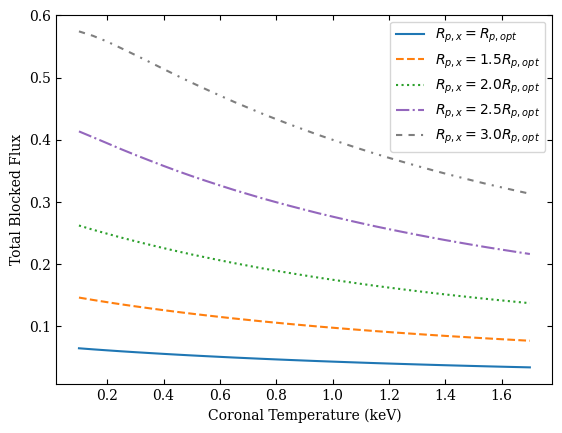

In [15]:
#try 0.1 to 1.7 keV
TArr = np.arange(0.1,1.71,0.05)

#get emission scale height in stellar radii
HeArr = xf.HfromT(TArr, Rs, Ms)
#get emission scale height in batman coordinates
heArr = xf.hfromH(HeArr)

#photosphere edge in batman coords
RxArr = xf.calcRx(heArr, Nscale)
#empty list for the intVals
intValsArr = []
#integral values
for j,he_i in enumerate(heArr):
    intValsArr.append(xf.get_intVals(he_i,Nscale)) 
    

#set up arrays
fluxes1_0 = np.zeros(shape=(len(heArr),numBins))
fluxes1_5 = np.zeros(shape=(len(heArr),numBins))
fluxes2_0 = np.zeros(shape=(len(heArr),numBins))
fluxes2_5 = np.zeros(shape=(len(heArr),numBins))
fluxes3_0 = np.zeros(shape=(len(heArr),numBins))

#loop over radii
for j,iv in enumerate(intValsArr):
    fluxes1_0[j] = change_h_rad_b(mod, iv, 1.0, 0.66, params, RxArr[j], aRs)
    fluxes1_5[j] = change_h_rad_b(mod, iv, 1.5, 0.66, params, RxArr[j], aRs)
    fluxes2_0[j] = change_h_rad_b(mod, iv, 2.0, 0.66, params, RxArr[j], aRs)
    fluxes2_5[j] = change_h_rad_b(mod, iv, 2.5, 0.66, params, RxArr[j], aRs)
    fluxes3_0[j] = change_h_rad_b(mod, iv, 3.0, 0.66, params, RxArr[j], aRs)


    
#find total light missing per point
miss1_0 = np.trapz((1-fluxes1_0), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss1_5 = np.trapz((1-fluxes1_5), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2_0 = np.trapz((1-fluxes2_0), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2_5 = np.trapz((1-fluxes2_5), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss3_0 = np.trapz((1-fluxes3_0), axis=1, dx=np.mean(np.diff(binPhases))) * 100


#plot
plt.plot(TArr,miss1_0, label='$R_{p,x} = R_{p,opt}$') 
plt.plot(TArr,miss1_5, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
plt.plot(TArr,miss2_0, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
plt.plot(TArr,miss2_5, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
plt.plot(TArr,miss3_0, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')


plt.xlabel('Coronal Temperature (keV)')
plt.ylabel('Total Blocked Flux')
plt.legend()

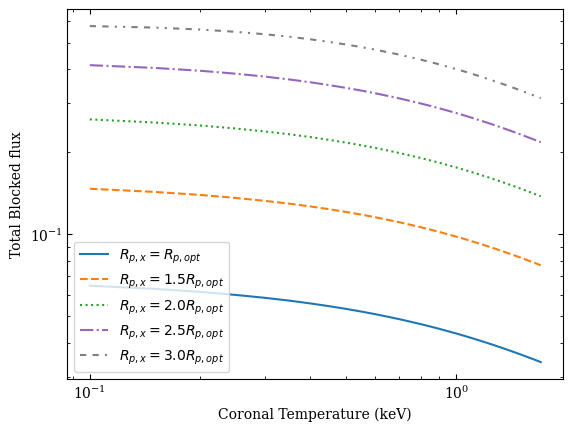

In [16]:
plt.plot(TArr,miss1_0, label='$R_{p,x} = R_{p,opt}$') 
plt.plot(TArr,miss1_5, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
plt.plot(TArr,miss2_0, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
plt.plot(TArr,miss2_5, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
plt.plot(TArr,miss3_0, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Coronal Temperature (keV)')
plt.ylabel('Total Blocked flux')
plt.legend()

In [17]:
#log the radii and blocked fluxes
logT = np.log10(TArr)
log1_0 = np.log10(miss1_0)
log1_5 = np.log10(miss1_5)
log2_0 = np.log10(miss2_0)
log2_5 = np.log10(miss2_5)
log3_0 = np.log10(miss3_0)

#linear regression
lr1_0 = linregress(logT,log1_0)
lr1_5 = linregress(logT,log1_5)
lr2_0 = linregress(logT,log2_0)
lr2_5 = linregress(logT,log2_5)
lr3_0 = linregress(logT,log3_0)

print(lr1_0)
print(lr1_5)
print(lr2_0)
print(lr2_5)
print(lr3_0)

LinregressResult(slope=-0.25118658122110266, intercept=-1.37397457048296, rvalue=-0.9613695423300995, pvalue=6.322345333266201e-19, stderr=0.012917244182269472, intercept_stderr=0.004438784083908137)
LinregressResult(slope=-0.251830544531576, intercept=-1.0203360922757208, rvalue=-0.9611901332974585, pvalue=6.784671954202002e-19, stderr=0.01298222640924536, intercept_stderr=0.0044611140848562795)
LinregressResult(slope=-0.25335849915460334, intercept=-0.7679222497179851, rvalue=-0.9610691590745207, pvalue=7.114019494735649e-19, stderr=0.013082578134262463, intercept_stderr=0.00449559819257409)
LinregressResult(slope=-0.25521115812244255, intercept=-0.5693648387464137, rvalue=-0.9596550737995384, pvalue=1.2247062615453913e-18, stderr=0.013430368484621969, intercept_stderr=0.004615110237862483)
LinregressResult(slope=-0.24291475539079432, intercept=-0.4093967407269151, rvalue=-0.9500050449632095, pvalue=3.1807557746839756e-17, stderr=0.014339304789943651, intercept_stderr=0.0049274502345

## b=0

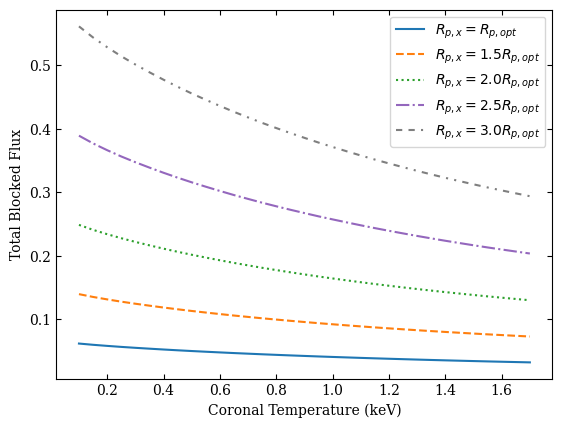

In [18]:
#set up arrays
fluxes1_0b0 = np.zeros(shape=(len(heArr),numBins))
fluxes1_5b0 = np.zeros(shape=(len(heArr),numBins))
fluxes2_0b0 = np.zeros(shape=(len(heArr),numBins))
fluxes2_5b0 = np.zeros(shape=(len(heArr),numBins))
fluxes3_0b0 = np.zeros(shape=(len(heArr),numBins))


#loop over radii
for j,iv in enumerate(intValsArr):
    fluxes1_0b0[j] = change_h_rad_b(mod, iv, 1.0, 0, params, RxArr[j], aRs)
    fluxes1_5b0[j] = change_h_rad_b(mod, iv, 1.5, 0, params, RxArr[j], aRs)
    fluxes2_0b0[j] = change_h_rad_b(mod, iv, 2.0, 0, params, RxArr[j], aRs)
    fluxes2_5b0[j] = change_h_rad_b(mod, iv, 2.5, 0, params, RxArr[j], aRs)
    fluxes3_0b0[j] = change_h_rad_b(mod, iv, 3.0, 0, params, RxArr[j], aRs)

    
#find total light missing per point
miss1_0b0 = np.trapz((1-fluxes1_0b0), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss1_5b0 = np.trapz((1-fluxes1_5b0), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2_0b0 = np.trapz((1-fluxes2_0b0), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2_5b0 = np.trapz((1-fluxes2_5b0), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss3_0b0 = np.trapz((1-fluxes3_0b0), axis=1, dx=np.mean(np.diff(binPhases))) * 100


#plot
plt.plot(TArr, miss1_0b0, label='$R_{p,x} = R_{p,opt}$') 
plt.plot(TArr, miss1_5b0, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
plt.plot(TArr, miss2_0b0, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
plt.plot(TArr, miss2_5b0, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
plt.plot(TArr, miss3_0b0, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

plt.xlabel('Coronal Temperature (keV)')
plt.ylabel('Total Blocked Flux')
plt.legend()

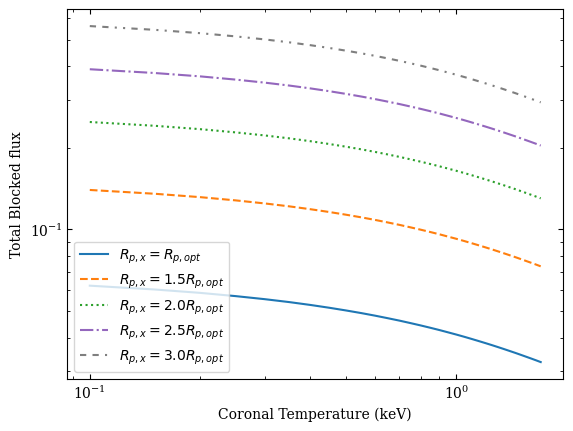

In [19]:
#plot
plt.plot(TArr, miss1_0b0, label='$R_{p,x} = R_{p,opt}$') 
plt.plot(TArr, miss1_5b0, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
plt.plot(TArr, miss2_0b0, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
plt.plot(TArr, miss2_5b0, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
plt.plot(TArr, miss3_0b0, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Coronal Temperature (keV)')
plt.ylabel('Total Blocked flux')
plt.legend()

In [20]:
#log the radii and blocked fluxes
logT = np.log10(TArr)
log1_0b0 = np.log10(miss1_0b0)
log1_5b0 = np.log10(miss1_5b0)
log2_0b0 = np.log10(miss2_0b0)
log2_5b0 = np.log10(miss2_5b0)
log3_0b0 = np.log10(miss3_0b0)

#linear regression
lr1_0b0 = linregress(logT,log1_0b0)
lr1_5b0 = linregress(logT,log1_5b0)
lr2_0b0 = linregress(logT,log2_0b0)
lr2_5b0 = linregress(logT,log2_5b0)
lr3_0b0 = linregress(logT,log3_0b0)

print(lr1_0b0)
print(lr1_5b0)
print(lr2_0b0)
print(lr2_5b0)
print(lr3_0b0)

LinregressResult(slope=-0.25120683288838075, intercept=-1.3970372054372873, rvalue=-0.9662616552715386, pvalue=8.018461220218094e-20, stderr=0.01202647620661918, intercept_stderr=0.004132687314583388)
LinregressResult(slope=-0.25114867497115656, intercept=-1.044546453251543, rvalue=-0.9661846243384999, pvalue=8.302552036488367e-20, stderr=0.012038134141506547, intercept_stderr=0.0041366933591466945)
LinregressResult(slope=-0.25110294137023836, intercept=-0.7942190860496287, rvalue=-0.9660886140685108, pvalue=8.669794042531225e-20, stderr=0.0120539199534095, intercept_stderr=0.004142117876144103)
LinregressResult(slope=-0.251037135262166, intercept=-0.5998099200081963, rvalue=-0.9659585780221125, pvalue=9.191399182008263e-20, stderr=0.012075069747855617, intercept_stderr=0.004149385631529126)
LinregressResult(slope=-0.25096880175925507, intercept=-0.44070160965848004, rvalue=-0.9657968141468609, pvalue=9.88116640730968e-20, stderr=0.012101960061391377, intercept_stderr=0.004158626015472

## b=1

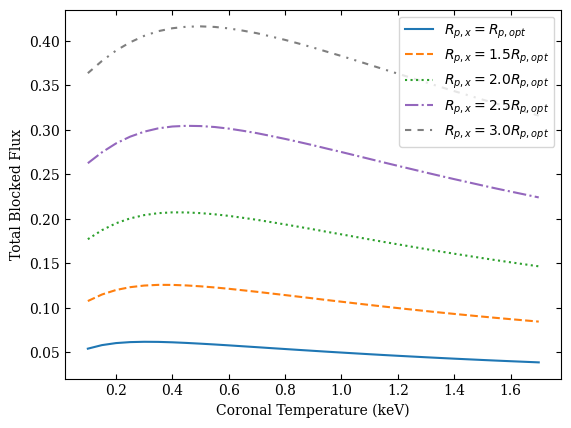

In [21]:
#set up arrays
fluxes1_0b1 = np.zeros(shape=(len(heArr),numBins))
fluxes1_5b1 = np.zeros(shape=(len(heArr),numBins))
fluxes2_0b1 = np.zeros(shape=(len(heArr),numBins))
fluxes2_5b1 = np.zeros(shape=(len(heArr),numBins))
fluxes3_0b1 = np.zeros(shape=(len(heArr),numBins))


#loop over radii
for j,iv in enumerate(intValsArr):
    fluxes1_0b1[j] = change_h_rad_b(mod, iv, 1.0, 1, params, RxArr[j], aRs)
    fluxes1_5b1[j] = change_h_rad_b(mod, iv, 1.5, 1, params, RxArr[j], aRs)
    fluxes2_0b1[j] = change_h_rad_b(mod, iv, 2.0, 1, params, RxArr[j], aRs)
    fluxes2_5b1[j] = change_h_rad_b(mod, iv, 2.5, 1, params, RxArr[j], aRs)
    fluxes3_0b1[j] = change_h_rad_b(mod, iv, 3.0, 1, params, RxArr[j], aRs)

    
#find total light missing per point
miss1_0b1 = np.trapz((1-fluxes1_0b1), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss1_5b1 = np.trapz((1-fluxes1_5b1), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2_0b1 = np.trapz((1-fluxes2_0b1), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2_5b1 = np.trapz((1-fluxes2_5b1), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss3_0b1 = np.trapz((1-fluxes3_0b1), axis=1, dx=np.mean(np.diff(binPhases))) * 100


#plot
plt.plot(TArr, miss1_0b1, label='$R_{p,x} = R_{p,opt}$') 
plt.plot(TArr, miss1_5b1, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
plt.plot(TArr, miss2_0b1, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
plt.plot(TArr, miss2_5b1, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
plt.plot(TArr, miss3_0b1, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

plt.xlabel('Coronal Temperature (keV)')
plt.ylabel('Total Blocked Flux')
plt.legend()

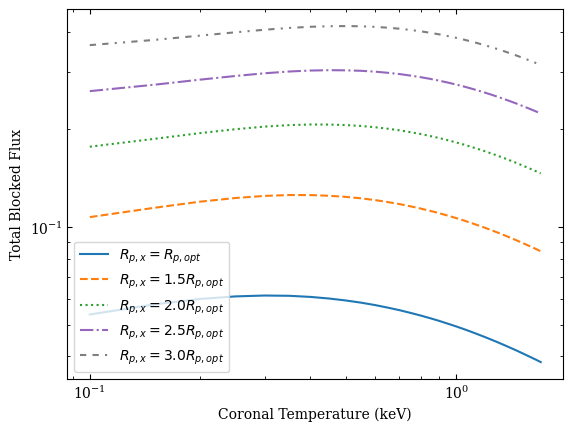

In [22]:
#plot
plt.plot(TArr, miss1_0b1, label='$R_{p,x} = R_{p,opt}$') 
plt.plot(TArr, miss1_5b1, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
plt.plot(TArr, miss2_0b1, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
plt.plot(TArr, miss2_5b1, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
plt.plot(TArr, miss3_0b1, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Coronal Temperature (keV)')
plt.ylabel('Total Blocked Flux')
plt.legend()

In [23]:
#log the radii and blocked fluxes
logT = np.log10(TArr)
log1_0b1 = np.log10(miss1_0b1)
log1_5b1 = np.log10(miss1_5b1)
log2_0b1 = np.log10(miss2_0b1)
log2_5b1 = np.log10(miss2_5b1)
log3_0b1 = np.log10(miss3_0b1)

#linear regression
lr1_0b1 = linregress(logT,log1_0b1)
lr1_5b1 = linregress(logT,log1_5b1)
lr2_0b1 = linregress(logT,log2_0b1)
lr2_5b1 = linregress(logT,log2_5b1)
lr3_0b1 = linregress(logT,log3_0b1)

print(lr1_0b1)
print(lr1_5b1)
print(lr2_0b1)
print(lr2_5b1)
print(lr3_0b1)

LinregressResult(slope=-0.1702048082318621, intercept=-1.3212053172440328, rvalue=-0.8141994609447827, pvalue=8.230122064542808e-09, stderr=0.021798477857850322, intercept_stderr=0.00749066404594746)
LinregressResult(slope=-0.12812081126687194, intercept=-0.9885902448497565, rvalue=-0.7330288137214168, pvalue=1.2263460458794297e-06, stderr=0.02135270373270059, intercept_stderr=0.0073374815974458895)
LinregressResult(slope=-0.1001522256540234, intercept=-0.7561061940755845, rvalue=-0.6660860997224997, pvalue=2.3261204116566805e-05, stderr=0.020142592054096648, intercept_stderr=0.006921647973574981)
LinregressResult(slope=-0.08118225154164814, intercept=-0.578015792063085, rvalue=-0.6154034976620028, pvalue=0.00013804635836773505, stderr=0.018675122508914097, intercept_stderr=0.006417377839104875)
LinregressResult(slope=-0.0682534262682506, intercept=-0.43402434212067964, rvalue=-0.5809694860305294, pvalue=0.0003924465893940729, stderr=0.017174134371610108, intercept_stderr=0.00590158962

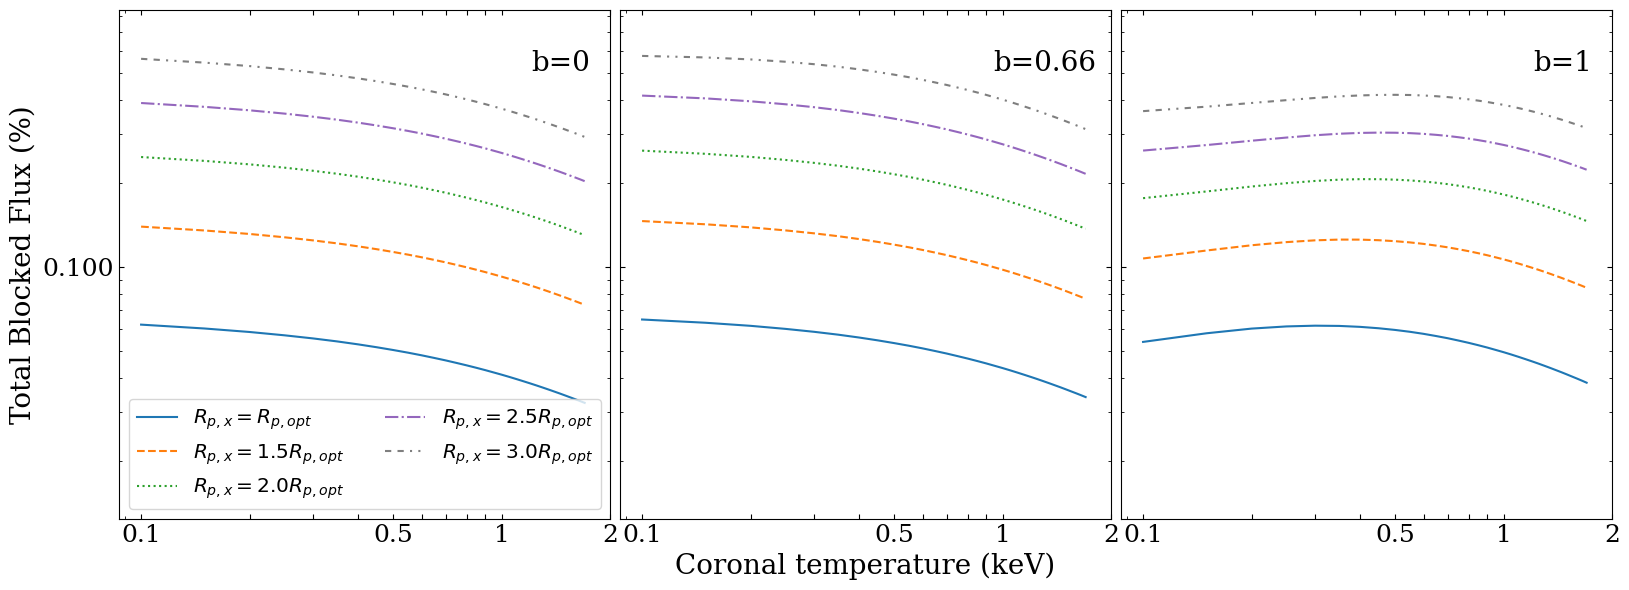

In [24]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(16.4,6.0))

ax1 = fig.add_subplot(131)

ax1.plot(TArr, miss1_0b0, label='$R_{p,x} = R_{p,opt}$') 
ax1.plot(TArr, miss1_5b0, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
ax1.plot(TArr, miss2_0b0, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
ax1.plot(TArr, miss2_5b0, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
ax1.plot(TArr, miss3_0b0, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Total Blocked Flux (%)',fontsize=20)
ax1.legend(fontsize=14.5, loc='lower left', ncols=2)
ax1.tick_params(labelsize=18)
ax1.tick_params(axis='x', which='minor', labelsize=18)
ax1.set_ylim(0.0124,0.84)
ax1.set_xticks(np.append(np.arange(0.1,1.01,0.1),2), labels=['0.1','','','','0.5','','','','','1','2'])
ax1.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.annotate('b=0', xy=(0.84, 0.88), xycoords='axes fraction', fontsize=20)


ax2 = fig.add_subplot(132)

ax2.plot(TArr,miss1_0, label='$R_{p,x} = R_{p,opt}$') 
ax2.plot(TArr,miss1_5, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
ax2.plot(TArr,miss2_0, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
ax2.plot(TArr,miss2_5, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
ax2.plot(TArr,miss3_0, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Coronal temperature (keV)',fontsize=20)
ax2.tick_params(labelsize=18)
ax2.tick_params(axis='x', which='minor', labelsize=18)
ax2.set_xticks(np.append(np.arange(0.1,1.01,0.1),2), labels=['0.1','','','','0.5','','','','','1','2'])
ax2.set_yticklabels([])
ax2.set_ylim(0.0124,0.84)
ax2.annotate('b=0.66', xy=(0.76, 0.88), xycoords='axes fraction', fontsize=20)


ax3 = fig.add_subplot(133)

ax3.plot(TArr, miss1_0b1, label='$R_{p,x} = R_{p,opt}$') 
ax3.plot(TArr, miss1_5b1, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
ax3.plot(TArr, miss2_0b1, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
ax3.plot(TArr, miss2_5b1, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
ax3.plot(TArr, miss3_0b1, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.tick_params(labelsize=18)
ax3.tick_params(axis='x', which='minor', labelsize=18)
ax3.set_xticks(np.append(np.arange(0.1,1.01,0.1),2), labels=['0.1','','','','0.5','','','','','1','2'])
ax3.set_yticklabels([])
ax3.set_ylim(0.0124,0.84)
ax3.annotate('b=1', xy=(0.84, 0.88), xycoords='axes fraction', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(wspace=0.02)

plt.savefig('detectability_varyT.pdf', dpi=300)

# Try varying b now at fixed R and T

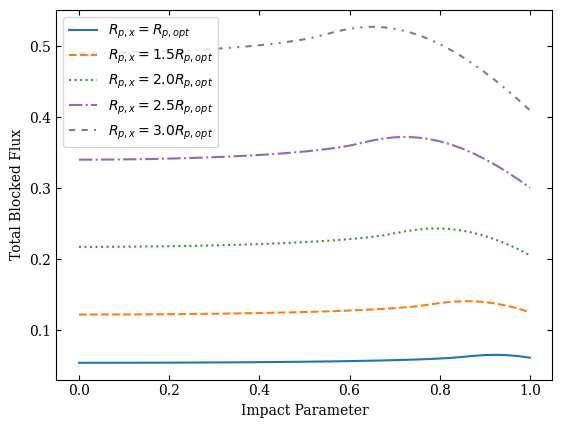

In [25]:
#try 0.1 to 1.7 keV
bArr = np.arange(0.0,1.01,0.025)

#set up arrays
fluxes1_0b = np.zeros(shape=(len(bArr),numBins))
fluxes1_5b = np.zeros(shape=(len(bArr),numBins))
fluxes2_0b = np.zeros(shape=(len(bArr),numBins))
fluxes2_5b = np.zeros(shape=(len(bArr),numBins))
fluxes3_0b = np.zeros(shape=(len(bArr),numBins))


#loop over radii
for k,bi in enumerate(bArr):
    fluxes1_0b[k] = change_h_rad_b(mod, intVals, 1.0, bi, params, Rx, aRs)
    fluxes1_5b[k] = change_h_rad_b(mod, intVals, 1.5, bi, params, Rx, aRs)
    fluxes2_0b[k] = change_h_rad_b(mod, intVals, 2.0, bi, params, Rx, aRs)
    fluxes2_5b[k] = change_h_rad_b(mod, intVals, 2.5, bi, params, Rx, aRs)
    fluxes3_0b[k] = change_h_rad_b(mod, intVals, 3.0, bi, params, Rx, aRs)

    
#find total light missing per point
miss1_0b = np.trapz((1-fluxes1_0b), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss1_5b = np.trapz((1-fluxes1_5b), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2_0b = np.trapz((1-fluxes2_0b), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2_5b = np.trapz((1-fluxes2_5b), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss3_0b = np.trapz((1-fluxes3_0b), axis=1, dx=np.mean(np.diff(binPhases))) * 100


#plot
plt.plot(bArr,miss1_0b, label='$R_{p,x} = R_{p,opt}$') 
plt.plot(bArr,miss1_5b, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
plt.plot(bArr,miss2_0b, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
plt.plot(bArr,miss2_5b, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
plt.plot(bArr,miss3_0b, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')


plt.xlabel('Impact Parameter')
plt.ylabel('Total Blocked Flux')
plt.legend()

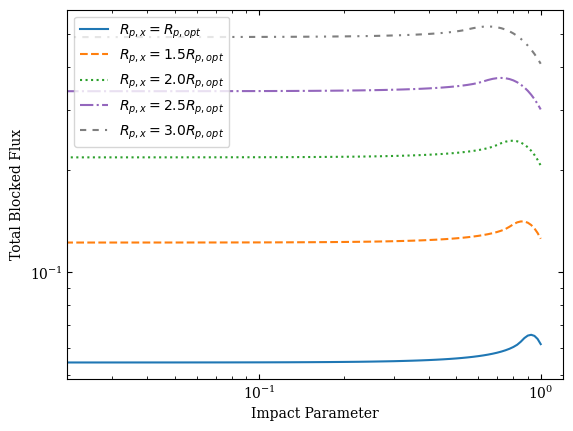

In [26]:
#plot
plt.plot(bArr,miss1_0b, label='$R_{p,x} = R_{p,opt}$') 
plt.plot(bArr,miss1_5b, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
plt.plot(bArr,miss2_0b, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
plt.plot(bArr,miss2_5b, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
plt.plot(bArr,miss3_0b, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Impact Parameter')
plt.ylabel('Total Blocked Flux')
plt.legend()

## Now with 1 keV

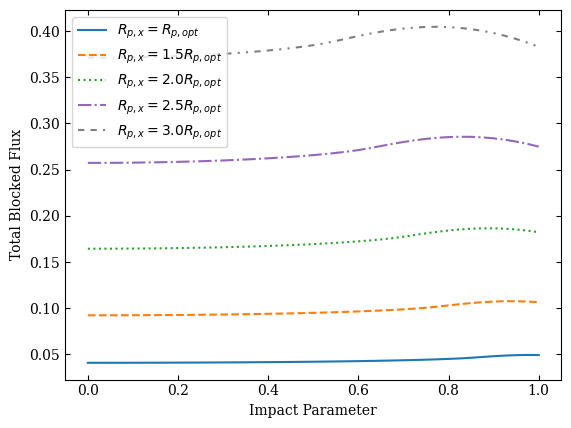

In [27]:
#set up arrays
fluxes1_0b100 = np.zeros(shape=(len(bArr),numBins))
fluxes1_5b100 = np.zeros(shape=(len(bArr),numBins))
fluxes2_0b100 = np.zeros(shape=(len(bArr),numBins))
fluxes2_5b100 = np.zeros(shape=(len(bArr),numBins))
fluxes3_0b100 = np.zeros(shape=(len(bArr),numBins))


#loop over radii
for k,bi in enumerate(bArr):
    fluxes1_0b100[k] = change_h_rad_b(mod, intVals3, 1.0, bi, params, Rx3, aRs)
    fluxes1_5b100[k] = change_h_rad_b(mod, intVals3, 1.5, bi, params, Rx3, aRs)
    fluxes2_0b100[k] = change_h_rad_b(mod, intVals3, 2.0, bi, params, Rx3, aRs)
    fluxes2_5b100[k] = change_h_rad_b(mod, intVals3, 2.5, bi, params, Rx3, aRs)
    fluxes3_0b100[k] = change_h_rad_b(mod, intVals3, 3.0, bi, params, Rx3, aRs)

    
#find total light missing per point
miss1_0b100 = np.trapz((1-fluxes1_0b100), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss1_5b100 = np.trapz((1-fluxes1_5b100), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2_0b100 = np.trapz((1-fluxes2_0b100), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2_5b100 = np.trapz((1-fluxes2_5b100), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss3_0b100 = np.trapz((1-fluxes3_0b100), axis=1, dx=np.mean(np.diff(binPhases))) * 100


#plot
plt.plot(bArr,miss1_0b100, label='$R_{p,x} = R_{p,opt}$') 
plt.plot(bArr,miss1_5b100, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
plt.plot(bArr,miss2_0b100, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
plt.plot(bArr,miss2_5b100, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
plt.plot(bArr,miss3_0b100, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')


plt.xlabel('Impact Parameter')
plt.ylabel('Total Blocked Flux')
plt.legend()

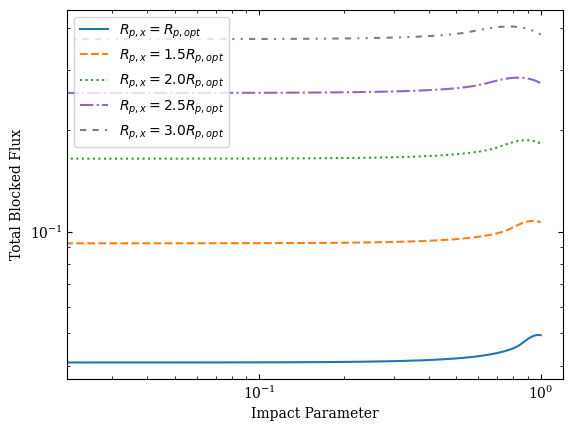

In [28]:
#plot
plt.plot(bArr,miss1_0b100, label='$R_{p,x} = R_{p,opt}$') 
plt.plot(bArr,miss1_5b100, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
plt.plot(bArr,miss2_0b100, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
plt.plot(bArr,miss2_5b100, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
plt.plot(bArr,miss3_0b100, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Impact Parameter')
plt.ylabel('Total Blocked Flux')
plt.legend()

## Now with 0.05 keV

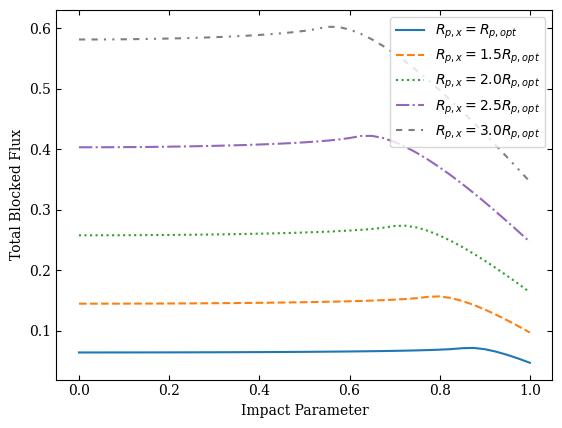

In [29]:
#set up arrays
fluxes1_0b5 = np.zeros(shape=(len(bArr),numBins))
fluxes1_5b5 = np.zeros(shape=(len(bArr),numBins))
fluxes2_0b5 = np.zeros(shape=(len(bArr),numBins))
fluxes2_5b5 = np.zeros(shape=(len(bArr),numBins))
fluxes3_0b5 = np.zeros(shape=(len(bArr),numBins))


#loop over radii
for k,bi in enumerate(bArr):
    fluxes1_0b5[k] = change_h_rad_b(mod, intVals2, 1.0, bi, params, Rx2, aRs)
    fluxes1_5b5[k] = change_h_rad_b(mod, intVals2, 1.5, bi, params, Rx2, aRs)
    fluxes2_0b5[k] = change_h_rad_b(mod, intVals2, 2.0, bi, params, Rx2, aRs)
    fluxes2_5b5[k] = change_h_rad_b(mod, intVals2, 2.5, bi, params, Rx2, aRs)
    fluxes3_0b5[k] = change_h_rad_b(mod, intVals2, 3.0, bi, params, Rx2, aRs)

    
#find total light missing per point
miss1_0b5 = np.trapz((1-fluxes1_0b5), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss1_5b5 = np.trapz((1-fluxes1_5b5), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2_0b5 = np.trapz((1-fluxes2_0b5), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2_5b5 = np.trapz((1-fluxes2_5b5), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss3_0b5 = np.trapz((1-fluxes3_0b5), axis=1, dx=np.mean(np.diff(binPhases))) * 100


#plot
plt.plot(bArr,miss1_0b5, label='$R_{p,x} = R_{p,opt}$') 
plt.plot(bArr,miss1_5b5, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
plt.plot(bArr,miss2_0b5, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
plt.plot(bArr,miss2_5b5, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
plt.plot(bArr,miss3_0b5, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')


plt.xlabel('Impact Parameter')
plt.ylabel('Total Blocked Flux')
plt.legend()

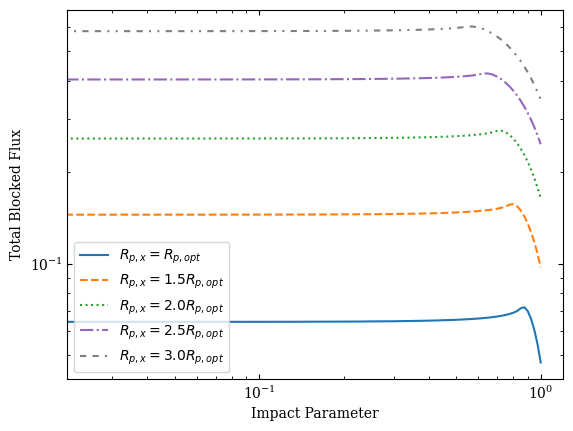

In [30]:
#plot
plt.plot(bArr,miss1_0b5, label='$R_{p,x} = R_{p,opt}$') 
plt.plot(bArr,miss1_5b5, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
plt.plot(bArr,miss2_0b5, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
plt.plot(bArr,miss2_5b5, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
plt.plot(bArr,miss3_0b5, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Impact Parameter')
plt.ylabel('Total Blocked Flux')
plt.legend()

## Now with b=1.75 keV

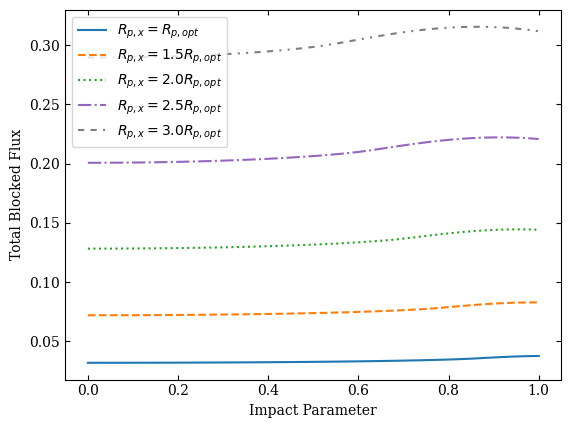

In [31]:
#set up arrays
fluxes1_0b175 = np.zeros(shape=(len(bArr),numBins))
fluxes1_5b175 = np.zeros(shape=(len(bArr),numBins))
fluxes2_0b175 = np.zeros(shape=(len(bArr),numBins))
fluxes2_5b175 = np.zeros(shape=(len(bArr),numBins))
fluxes3_0b175 = np.zeros(shape=(len(bArr),numBins))


#loop over radii
for k,bi in enumerate(bArr):
    fluxes1_0b175[k] = change_h_rad_b(mod, intVals4, 1.0, bi, params, Rx4, aRs)
    fluxes1_5b175[k] = change_h_rad_b(mod, intVals4, 1.5, bi, params, Rx4, aRs)
    fluxes2_0b175[k] = change_h_rad_b(mod, intVals4, 2.0, bi, params, Rx4, aRs)
    fluxes2_5b175[k] = change_h_rad_b(mod, intVals4, 2.5, bi, params, Rx4, aRs)
    fluxes3_0b175[k] = change_h_rad_b(mod, intVals4, 3.0, bi, params, Rx4, aRs)

    
#find total light missing per point
miss1_0b175 = np.trapz((1-fluxes1_0b175), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss1_5b175 = np.trapz((1-fluxes1_5b175), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2_0b175 = np.trapz((1-fluxes2_0b175), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss2_5b175 = np.trapz((1-fluxes2_5b175), axis=1, dx=np.mean(np.diff(binPhases))) * 100
miss3_0b175 = np.trapz((1-fluxes3_0b175), axis=1, dx=np.mean(np.diff(binPhases))) * 100


#plot
plt.plot(bArr,miss1_0b175, label='$R_{p,x} = R_{p,opt}$') 
plt.plot(bArr,miss1_5b175, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
plt.plot(bArr,miss2_0b175, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
plt.plot(bArr,miss2_5b175, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
plt.plot(bArr,miss3_0b175, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')


plt.xlabel('Impact Parameter')
plt.ylabel('Total Blocked Flux')
plt.legend()

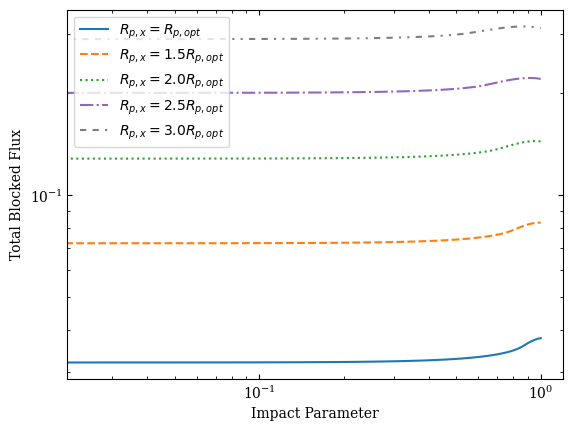

In [32]:
#plot
plt.plot(bArr,miss1_0b175, label='$R_{p,x} = R_{p,opt}$') 
plt.plot(bArr,miss1_5b175, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
plt.plot(bArr,miss2_0b175, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
plt.plot(bArr,miss2_5b175, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
plt.plot(bArr,miss3_0b175, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Impact Parameter')
plt.ylabel('Total Blocked Flux')
plt.legend()

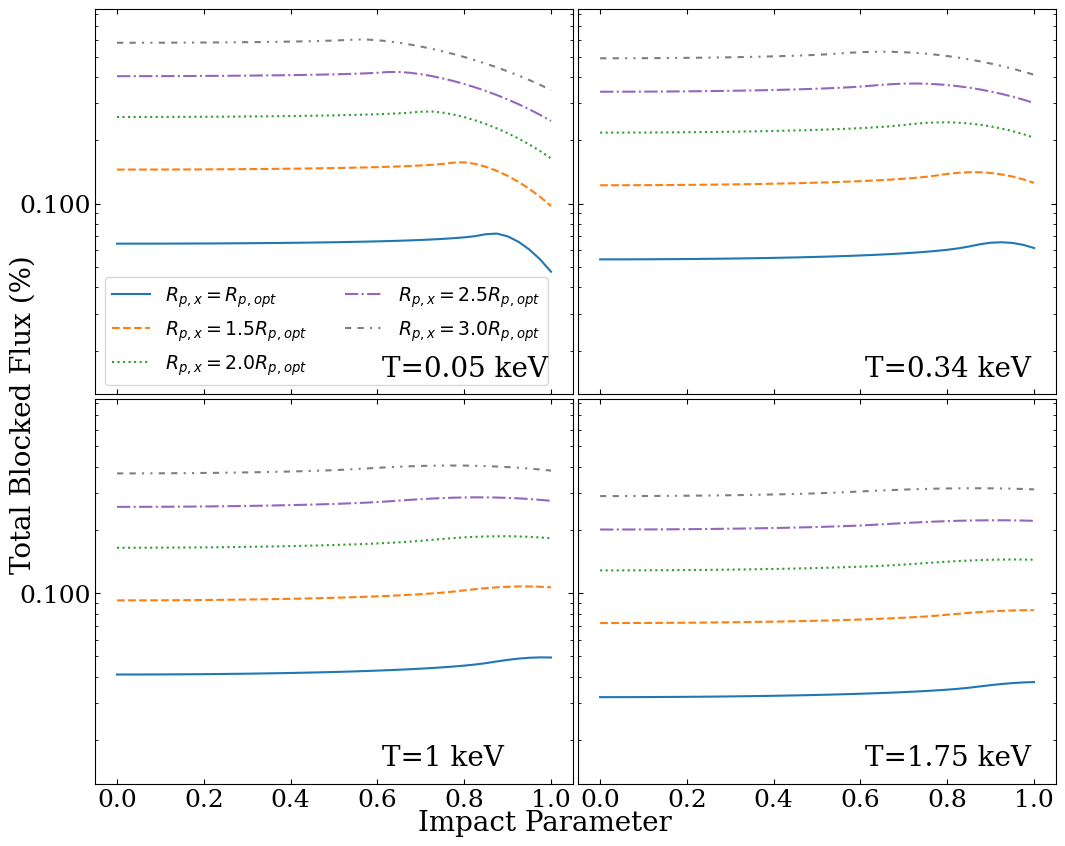

In [33]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(10.8,8.4))

ax1 = fig.add_subplot(221)

ax1.plot(bArr,miss1_0b5, label='$R_{p,x} = R_{p,opt}$') 
ax1.plot(bArr,miss1_5b5, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
ax1.plot(bArr,miss2_0b5, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
ax1.plot(bArr,miss2_5b5, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
ax1.plot(bArr,miss3_0b5, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

ax1.set_yscale('log')
ax1.legend(fontsize=13.6, loc='lower left', ncols=2).set_zorder(1)
ax1.tick_params(labelsize=18)
ax1.tick_params(axis='x', which='minor', labelsize=18)
ax1.set_xticklabels([])
ax1.set_ylim(0.0124,0.84)
ax1.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.annotate('T=0.05 keV', xy=(0.6, 0.048), xycoords='axes fraction', fontsize=20, zorder=2)


ax2 = fig.add_subplot(222)

ax2.plot(bArr,miss1_0b, label='$R_{p,x} = R_{p,opt}$') 
ax2.plot(bArr,miss1_5b, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
ax2.plot(bArr,miss2_0b, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
ax2.plot(bArr,miss2_5b, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
ax2.plot(bArr,miss3_0b, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

ax2.set_yscale('log')
ax2.tick_params(labelsize=18)
ax2.tick_params(axis='x', which='minor', labelsize=18)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_ylim(0.0124,0.84)
ax2.annotate('T=0.34 keV', xy=(0.6, 0.048), xycoords='axes fraction', fontsize=20)


ax3 = fig.add_subplot(223)

ax3.plot(bArr,miss1_0b100, label='$R_{p,x} = R_{p,opt}$') 
ax3.plot(bArr,miss1_5b100, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
ax3.plot(bArr,miss2_0b100, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
ax3.plot(bArr,miss2_5b100, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
ax3.plot(bArr,miss3_0b100, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')
ax3.set_yscale('log')
ax3.tick_params(labelsize=18)
ax3.tick_params(axis='x', which='minor', labelsize=18)
ax3.set_ylim(0.0124,0.84)
ax3.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax3.annotate('T=1 keV', xy=(0.6, 0.048), xycoords='axes fraction', fontsize=20)


ax4 = fig.add_subplot(224)

ax4.plot(bArr,miss1_0b175, label='$R_{p,x} = R_{p,opt}$') 
ax4.plot(bArr,miss1_5b175, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
ax4.plot(bArr,miss2_0b175, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
ax4.plot(bArr,miss2_5b175, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
ax4.plot(bArr,miss3_0b175, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

ax4.set_yscale('log')
ax4.tick_params(labelsize=18)
ax4.tick_params(axis='x', which='minor', labelsize=18)
ax4.set_yticklabels([])
ax4.set_ylim(0.0124,0.84)

ax4.annotate('T=1.75 keV', xy=(0.6, 0.048), xycoords='axes fraction', fontsize=20)


fig.text(0.5, 0.005, 'Impact Parameter', ha='center', fontsize=20)
fig.text(0.005, 0.5, 'Total Blocked Flux (%)', va='center', rotation='vertical', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(left=0.084, bottom=0.06, wspace=0.012, hspace=0.012)

plt.savefig('detectability_varyb_2x2.pdf', dpi=300)

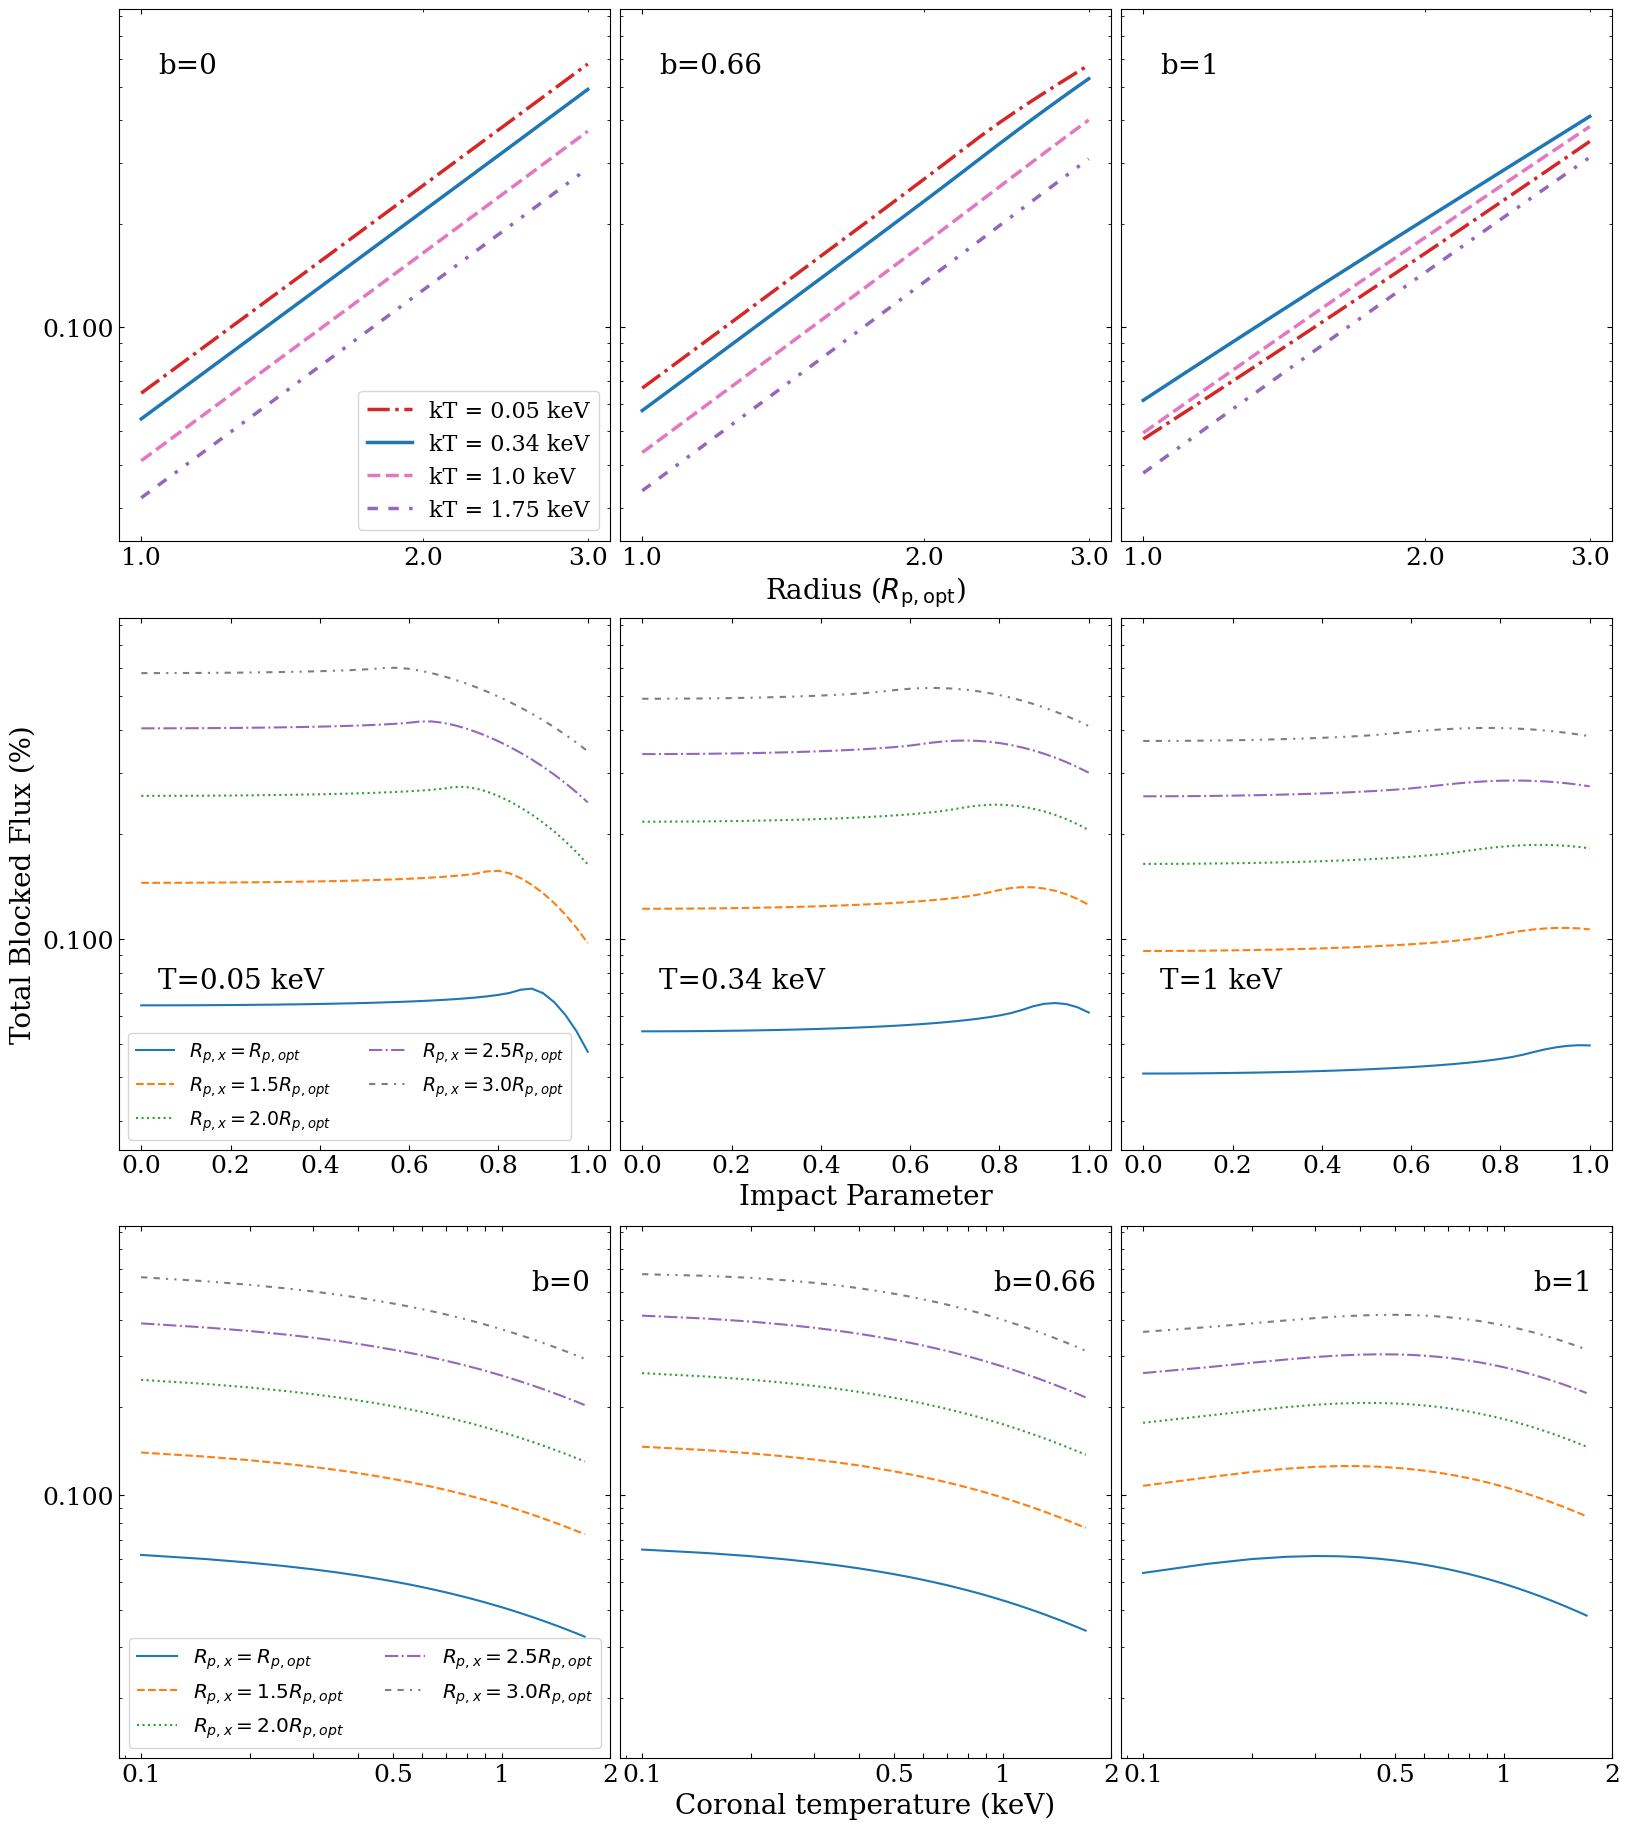

In [48]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(16.4,18.4))

ax1 = fig.add_subplot(331)

ax1.plot(radii,miss2b0, label='kT = %s keV' % T2, color='C3', ls='-.', lw=2.5)
ax1.plot(radii,miss1b0, label='kT = %s keV' % T, color='C0', lw=2.5)
ax1.plot(radii,miss3b0, label='kT = %s keV' % T3, color='C6', ls='--', lw=2.5)
ax1.plot(radii,miss4b0, label='kT = %s keV' % T4, color='C4', ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), lw=2.5)

ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.set_ylabel('Total Blocked Flux (%)',fontsize=20)
ax1.legend(fontsize=16, loc='lower right')
ax1.tick_params(labelsize=18)
ax1.tick_params(axis='x', which='minor', labelsize=18)
ax1.set_ylim(0.024,0.84)
ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.xaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.annotate('b=0', xy=(0.08, 0.88), xycoords='axes fraction', fontsize=20)


ax2 = fig.add_subplot(332)

ax2.plot(radii,miss2, label='kT = %s keV' % T2, color='C3', ls='-.', lw=2.5)
ax2.plot(radii,miss1, label='kT = %s keV' % T, color='C0', lw=2.5)
ax2.plot(radii,miss3, label='kT = %s keV' % T3, color='C6', ls='--', lw=2.5)
ax2.plot(radii,miss4, label='kT = %s keV' % T4, color='C4', ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), lw=2.5)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Radius ($R_{\rm p,opt}$)',fontsize=20)
ax2.tick_params(labelsize=18)
ax2.tick_params(axis='x', which='minor', labelsize=18)
ax2.set_yticklabels([])
ax2.set_ylim(0.024,0.84)
ax2.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax2.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.xaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
ax2.annotate('b=0.66', xy=(0.08, 0.88), xycoords='axes fraction', fontsize=20)


ax3 = fig.add_subplot(333)

ax3.plot(radii,miss2b1, label='kT = %s keV' % T2, color='C3', ls='-.', lw=2.5)
ax3.plot(radii,miss1b1, label='kT = %s keV' % T, color='C0', lw=2.5)
ax3.plot(radii,miss3b1, label='kT = %s keV' % T3, color='C6', ls='--', lw=2.5)
ax3.plot(radii,miss4b1, label='kT = %s keV' % T4, color='C4', ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), lw=2.5)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.tick_params(labelsize=18)
ax3.tick_params(axis='x', which='minor', labelsize=18)
ax3.set_yticklabels([])
ax3.set_ylim(0.024,0.84)
ax3.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax3.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax3.xaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
ax3.annotate('b=1', xy=(0.08, 0.88), xycoords='axes fraction', fontsize=20)





ax4 = fig.add_subplot(334)

ax4.plot(bArr,miss1_0b5, label='$R_{p,x} = R_{p,opt}$') 
ax4.plot(bArr,miss1_5b5, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
ax4.plot(bArr,miss2_0b5, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
ax4.plot(bArr,miss2_5b5, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
ax4.plot(bArr,miss3_0b5, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

ax4.set_yscale('log')
ax4.legend(fontsize=13.6, loc='lower left', ncols=2).set_zorder(1)
ax4.tick_params(labelsize=18)
ax4.tick_params(axis='x', which='minor', labelsize=18)
ax4.set_ylim(0.0248,0.84)
ax4.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax4.annotate('T=0.05 keV', xy=(0.08, 0.304), xycoords='axes fraction', fontsize=20, zorder=2)
ax4.set_ylabel('Total Blocked Flux (%)', fontsize=20)


ax5 = fig.add_subplot(335)

ax5.plot(bArr,miss1_0b, label='$R_{p,x} = R_{p,opt}$') 
ax5.plot(bArr,miss1_5b, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
ax5.plot(bArr,miss2_0b, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
ax5.plot(bArr,miss2_5b, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
ax5.plot(bArr,miss3_0b, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

ax5.set_yscale('log')
ax5.tick_params(labelsize=18)
ax5.tick_params(axis='x', which='minor', labelsize=18)
ax5.set_yticklabels([])
ax5.set_ylim(0.0248,0.84)
ax5.annotate('T=0.34 keV', xy=(0.08, 0.304), xycoords='axes fraction', fontsize=20)
ax5.set_xlabel('Impact Parameter', fontsize=20)


ax6 = fig.add_subplot(336)

ax6.plot(bArr,miss1_0b100, label='$R_{p,x} = R_{p,opt}$') 
ax6.plot(bArr,miss1_5b100, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
ax6.plot(bArr,miss2_0b100, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
ax6.plot(bArr,miss2_5b100, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
ax6.plot(bArr,miss3_0b100, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')
ax6.set_yscale('log')
ax6.tick_params(labelsize=18)
ax6.tick_params(axis='x', which='minor', labelsize=18)
ax6.set_yticklabels([])
ax6.set_ylim(0.0248,0.84)
ax6.annotate('T=1 keV', xy=(0.08, 0.304), xycoords='axes fraction', fontsize=20)





ax7 = fig.add_subplot(337)

ax7.plot(TArr, miss1_0b0, label='$R_{p,x} = R_{p,opt}$') 
ax7.plot(TArr, miss1_5b0, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
ax7.plot(TArr, miss2_0b0, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
ax7.plot(TArr, miss2_5b0, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
ax7.plot(TArr, miss3_0b0, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

ax7.set_xscale('log')
ax7.set_yscale('log')
#ax7.set_ylabel('Total Blocked Flux (%)',fontsize=20)
ax7.legend(fontsize=14.5, loc='lower left', ncols=2)
ax7.tick_params(labelsize=18)
ax7.tick_params(axis='x', which='minor', labelsize=18)
ax7.set_ylim(0.0124,0.84)
ax7.set_xticks(np.append(np.arange(0.1,1.01,0.1),2), labels=['0.1','','','','0.5','','','','','1','2'])
ax7.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax7.annotate('b=0', xy=(0.84, 0.88), xycoords='axes fraction', fontsize=20)


ax8 = fig.add_subplot(338)

ax8.plot(TArr,miss1_0, label='$R_{p,x} = R_{p,opt}$') 
ax8.plot(TArr,miss1_5, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
ax8.plot(TArr,miss2_0, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
ax8.plot(TArr,miss2_5, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
ax8.plot(TArr,miss3_0, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

ax8.set_xscale('log')
ax8.set_yscale('log')
ax8.set_xlabel(r'Coronal temperature (keV)',fontsize=20)
ax8.tick_params(labelsize=18)
ax8.tick_params(axis='x', which='minor', labelsize=18)
ax8.set_xticks(np.append(np.arange(0.1,1.01,0.1),2), labels=['0.1','','','','0.5','','','','','1','2'])
ax8.set_yticklabels([])
ax8.set_ylim(0.0124,0.84)
ax8.annotate('b=0.66', xy=(0.76, 0.88), xycoords='axes fraction', fontsize=20)


ax9 = fig.add_subplot(339)

ax9.plot(TArr, miss1_0b1, label='$R_{p,x} = R_{p,opt}$') 
ax9.plot(TArr, miss1_5b1, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
ax9.plot(TArr, miss2_0b1, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
ax9.plot(TArr, miss2_5b1, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')
ax9.plot(TArr, miss3_0b1, ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='$R_{p,x} = 3.0 R_{p,opt}$', color='C7')

ax9.set_xscale('log')
ax9.set_yscale('log')
ax9.tick_params(labelsize=18)
ax9.tick_params(axis='x', which='minor', labelsize=18)
ax9.set_xticks(np.append(np.arange(0.1,1.01,0.1),2), labels=['0.1','','','','0.5','','','','','1','2'])
ax9.set_yticklabels([])
ax9.set_ylim(0.0124,0.84)
ax9.annotate('b=1', xy=(0.84, 0.88), xycoords='axes fraction', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.144)

plt.savefig('detectability_all.pdf', dpi=300)